<a href="https://colab.research.google.com/github/LapTQ/image_captioning/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/hungpham13/Vietnamese-HTR.git

Cloning into 'Vietnamese-HTR'...
remote: Enumerating objects: 2403, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2403 (delta 0), reused 4 (delta 0), pack-reused 2399
Receiving objects: 100% (2403/2403), 427.59 MiB | 10.63 MiB/s, done.
Checking out files: 100% (2395/2395), done.


In [2]:
import os
import re
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path
import pickle

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
!head -20 '/content/Vietnamese-HTR/Data 1: Handwriting OCR for Vietnamese Address/0825_DataSamples 1/labels.json'

{
    "1.jpg": "Số 3 Nguyễn Ngọc Vũ, Hà Nội",
    "2.jpg": "Số 30 Nguyên Hồng, Láng Hạ, Đống Đa, Hà Nội",
    "3.jpg": "58 Thái Thịnh, Đống Đa, Hà Nội",
    "4.jpeg": "Số 370/8 khu phố 5B, phường Tân Biên, Biên Hòa, Đồng Nai",
    "5.jpg": "Vĩnh Trung Plaza, B, 255-257 đường Hùng Vương, phường Vĩnh Trung",
    "6.jpg": "Tòa nhà 34T, Hoàng Đạo Thúy, Hà Nội",
    "7.jpg": "40 Cát Linh, Đống Đa, Hà Nội",
    "8.jpg": "phòng 101, tầng 1, lô 04-TT5B, khu đô thị Tây Nam Linh Đàm",
    "9.JPG": "Nhà 87 ngõ 416 Đê La Thành",
    "10.JPG": "Up coworking Space, 89 Láng Hạ, Hà Nội",
    "11.jpg": "192 Ngô Đức Kế, quận 1, Hồ Chí Minh",
    "12.jpg": "số 5 Công Trường Mê Linh, phường Bến Nghé, quận 1",
    "13.jpg": "90A đường Mai Xuân Thưởng, tỉnh Gia Lai",
    "14.jpg": "96/7/12B Phạm Văn Đồng, thành phố Pleiku",
    "15.jpg": "168 Ngô Gia Tự, thành phố Hà Tĩnh"
}

In [3]:
train_img_dir = '/content/Vietnamese-HTR/Data 1: Handwriting OCR for Vietnamese Address/0916_Data Samples 2'
test_img_dir = '/content/Vietnamese-HTR/Data 1: Handwriting OCR for Vietnamese Address/1015_Private Test'

image_height, image_width = 120, 1900
vocab_size = 10000

# Fixed length allowed for any sequence
seq_length = 25

# Dimension for the image embeddings and token embeddings
embedding_dim = 512

# Per-layer units in the feed-forward network
units = 512

batch_size = 4
epochs = 30
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
print('Number of training images:', len(list(Path(train_img_dir).glob('*.png'))))
print('Number of testing images:', len(list(Path(test_img_dir).glob('*.png'))))

Number of training images: 1823
Number of testing images: 549


In [4]:
import json

train_json = json.load(
    open(train_img_dir + '/labels.json', 'r')
)

test_json = json.load(
    open(test_img_dir + '/labels.json', 'r')
)

train_data = {os.path.join(train_img_dir, image_name): '<start> ' + label + ' <end>' for image_name, label in train_json.items()}
test_data = {os.path.join(test_img_dir, image_name): '<start> ' + label + ' <end>' for image_name, label in test_json.items()}

In [5]:
def decode_and_resize(img_path):
    img_string = tf.io.read_file(img_path)
    img = tf.image.decode_png(img_string)

    # resize to desired shape
    # input is of int [0, 255], but output is of float [0, 255]
    img = tf.image.resize_with_pad(img, image_height, image_width)

    # invert color      ##############################
    img = 255 - img

    # preprocess_input accept input of type float [0, 255]
    img = keras.applications.densenet.preprocess_input(img)

    return img

strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace('<', '')
strip_chars = strip_chars.replace('>', '')
strip_chars = strip_chars.replace('/', '')
strip_chars = strip_chars.replace('-', '')

vectorization = keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_length,
    standardize=lambda label: tf.strings.regex_replace(label, "[%s]" % re.escape(strip_chars), "")
)

vectorization.adapt(list(train_data.values()))

def preprocess_input(img_path, label):
    return decode_and_resize(img_path), vectorization(label)

def make_dataset(img_paths, labels, training):
    assert training is True or training is False

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    dataset = dataset.map(preprocess_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=2000)
    # dataset = dataset.cache()
    if training: 
        dataset = dataset.shuffle(buffer_size=2000)
    dataset = dataset.batch(batch_size)

    return dataset


train_ds = make_dataset(
    train_data.keys(),
    train_data.values(),
    training = True
)
test_ds = make_dataset(
    test_data.keys(),
    test_data.values(),
    training = False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


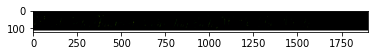

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[   2  389  951 1065    4   61    5   16   14   10    9   11    8    3
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


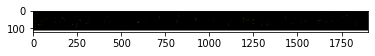

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[   2 1711   23   19   95    7   19   45    6  604 1375   39   99  366
    3    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


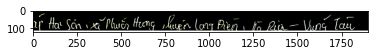

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[  2  23  34  26  56  51  57   6  28 232  83 168  71 113 114   3   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


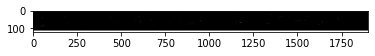

tf.Tensor(
[  2 388  77 123 814   4 495 232   5  38  10   9  11   8   3   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)


In [6]:
for images, labels in train_ds.take(1):
    for image, label in zip(images, labels):
        plt.imshow(image)
        plt.show()
        print(label)

In [ ]:
# i = 0
# for label in train_data.values():
#     print(
#         tf.strings.regex_replace(label, "[%s]" % re.escape("!\"#$%&'()*+,.:;=?@[\]^_`{|}~"), "")
#     )
#     i += 1
#     if i == 3:
#         break
    

In [ ]:
# vectorization.get_vocabulary()

In [ ]:
# print(list(json_file.values())[0])
# vectorization(list(train_data.values()))[:3]

In [7]:
base_model = keras.applications.DenseNet121(
    include_top=False,
    input_shape=(image_height, image_width, 3),

)
# get the feature map from DenseNet
base_model_out = base_model.output
# squash the feature map from shape [f_height, f_width, f_channel]
# to shape [f_height x f_width, f channel], we'll pass it through
# a CNN Encoder later on
base_model_out = keras.layers.Reshape(
    (-1, base_model_out.shape[-1])
)(base_model_out)

cnn_model = keras.models.Model(
    base_model.input,
    base_model_out
)

29097984/29084464 [==============================] - 0s 0us/step


In [8]:
class CNN_Encoder(keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()

        self.feature_extractor = keras.applications.DenseNet121(
            include_top=False,
            input_shape=(image_height, image_width, 3),

        )
        
        self.fc = keras.layers.Dense(embedding_dim)

    def call(self, x):
        # get the feature map from DenseNet
        x = self.feature_extractor(x)
        # squash the feature map from shape [f_height, f_width, f_channel]
        # to shape [f_height x f_width, f channel]
        x = keras.layers.Reshape((-1, x.shape[-1]))(x)
        # shape after fc == (f_height x f_width, embedding_dim)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [9]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape = (batch_size, f_height x f_width, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # print('BahdanauAttention: hidden_with_time_axis.shape == ', hidden_with_time_axis.shape)

        # attention_hidden_layer shape == (batch_size, f_height x f_width, units)
        attention_hidden_layer = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # score shape == (batch_size, f_height x f_width, 1)
        # this gives an unnormalized score for each image feature
        score = self.V(attention_hidden_layer)

        # print('BahdanauAttention: score.shape == ', score.shape)

        # attention_weights shape == (batch_size, f_height x f_width, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # print('BahdanauAttention: attention_weights.shape == ', attention_weights.shape)

        # context vector shape after sum = (batch_size, hidden_size)
        context_vector = attention_weights * features
        # print('BahdanauAttention: context_vector.shape == ', context_vector.shape)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


Bahdanau vs Luong

In [10]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # print('RNN_Decoder: context_vector.shape == ', context_vector.shape)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [11]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vectorization.vocabulary_size())

In [12]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(trues, preds):
    loss_ = loss_object(trues, preds)
    
    mask = tf.cast(
        tf.math.logical_not(tf.math.equal(trues, 0)),
        dtype=loss_.dtype
    )

    loss_ *= mask

    return tf.reduce_mean(loss_)

In [13]:
!mkdir checkpoints
!mkdir checkpoints/train

In [14]:
checkpoint_path = 'checkpoints/train'
ckpt = tf.train.Checkpoint(
    encoder=encoder,
    decoder=decoder,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt,
    checkpoint_path,
    max_to_keep=5
)

In [15]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [16]:
word_to_index = keras.layers.StringLookup(
    mask_token="",
    vocabulary=vectorization.get_vocabulary())
index_to_word = keras.layers.StringLookup(
    mask_token="",
    vocabulary=vectorization.get_vocabulary(),
    invert=True)

In [ ]:
loss_plot = []

In [17]:
@tf.function
def train_step(images, targets):
    # print('train_step: images.shape == ', images.shape)
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=targets.shape[0])

    dec_input = tf.expand_dims(
        [word_to_index('<start>')] * targets.shape[0],
        axis=1
    )

    with tf.GradientTape() as tape:
        features = encoder(images)

        for i in range(1, targets.shape[1]):
            # print('train_step: dec_input.shape == ', dec_input.shape)
            # print('train_step: features.shape == ', features.shape)
            # print('train_step: hidden.shape == ', hidden.shape)
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(targets[:, i], predictions)

            dec_input = tf.expand_dims(targets[:, i], 1)
    
    total_loss = loss / targets.shape[1]

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
# tf.config.run_functions_eagerly(False)

In [23]:
import time

epochs = 10

for epoch in range(start_epoch, epochs):
    start = time.time()
    total_loss = 0

    for batch, (images, targets) in enumerate(train_ds):
        
        print(targets.shape)
        break

        batch_loss, t_loss = train_step(images, targets)
        total_loss += t_loss

        if batch % 50 == 0:
            average_batch_loss = batch_loss.numpy() / int(targets.shape[1])
            print(f'Epoch: {epoch + 1} Batch: {batch} Loss: {average_batch_loss:.4f}')

    break

    loss_plot.append(total_loss / train_ds.cardinality().numpy())

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch: {epoch + 1} Loss: {total_loss/train_ds.cardinality().numpy():.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

(4, 25)


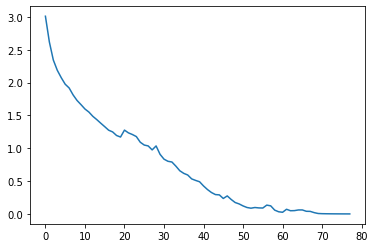

In [ ]:
plt.plot(loss_plot)

In [ ]:
# save checkpoint
!tar -czf drive/MyDrive/checkpoint/htr/checkpoints2.tar.gz ./checkpoints

In [ ]:
with open('drive/MyDrive/checkpoint/htr/loss_plot2.pkl', 'wb') as f:
    pickle.dump(loss_plot, f)

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# extract checkpoint archive
!tar -xf drive/MyDrive/checkpoint/htr/checkpoints.tar.gz -C ./

In [20]:
# load checkpoint
ckpt_path = tf.train.latest_checkpoint(checkpoint_path)
ckpt.restore(ckpt_path)

In [21]:
with open('drive/MyDrive/checkpoint/htr/loss_plot.pkl', 'rb') as f:
    loss_plot = pickle.load(f)

In [38]:
def evaluate(image):
    # image shape == (height, width, channels)

    # features shape == (1, f_heigt x f_width, f_channels)
    features = encoder(tf.expand_dims(image, axis=0))
    attention_plot = np.zeros((seq_length, features.shape[1]))

    hidden = decoder.reset_state(batch_size=1)

    dec_input = tf.expand_dims([word_to_index('<start>')], axis=0)
    result = []

    for i in range(seq_length):
        predictions, hidden, attention_weights = decoder(
            dec_input,
            features,
            hidden
        )

        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [28]:
for images, targets in train_ds:
    for image, target in zip(images, targets):
        # plt.figure(figsize=(15, 3))
        # plt.imshow(1 - image)
        # plt.show()
        result, attention_plot = evaluate(image)
        print("True:", ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in target if i.numpy() != 0]))
        print('Pred:', ' '.join(result))
    break

True: <start> Số 459 phố Kim Ngưu Phường Vĩnh Tuy Quận Hai Bà Trưng Hà Nội <end>
Pred: Số 459 phố Kim Ngưu Phường Vĩnh Tuy Quận Hai Bà Trưng Hà Nội <end>
True: <start> Km 948600 Quốc lộ 1A Xã Điện Thắng Bắc Huyện Điện Bàn Quảng Nam <end>
Pred: Km 948600 Quốc lộ 5A Xã Bạch Thắng Huyện Long Thành Quảng Nam <end>
True: <start> Khu 7 Thị Trấn ái Nghĩa Huyện Đại Lộc Quảng Nam <end>
Pred: Khu 7 Thị Trấn ái Nghĩa Huyện Đại Lộc Quảng Nam <end>
True: <start> Số 117 Hùng Vương Phường Sở Dầu Quận Hồng Bàng Hải Phòng <end>
Pred: Số 117 Hùng Vương Phường Sở Nghé Quận Hà Đông Hà Nội <end>


In [ ]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(60, 12))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (3, 59))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(1 - image / tf.reduce_max(image))
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


In [ ]:
for images, targets in train_ds:
    for image, target in zip(images, targets):
        result, attention_plot = evaluate(image)
        plot_attention(image, result, attention_plot)
        print("True:", ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in target if i.numpy() != 0]))
        print('Pred:', ' '.join(result))
    break

In [43]:
def evaluate(images, targets):
    # images shape == (batch_size, height, width, channels)

    # features shape == (batch_size, f_heigt x f_width, f_channels)
    features = encoder(images)

    hidden = decoder.reset_state(batch_size=targets.shape[0])

    results = tf.expand_dims([word_to_index('<start>')] * targets.shape[0], axis=1)

    for i in range(seq_length):
        predictions, hidden, attention_weights = decoder(
            results[..., -1:], #(4, 1)
            features,
            hidden
        )

        predicted_id = tf.expand_dims(
            tf.argmax(predictions, axis=-1),
            axis=-1
        )

        results = tf.concat([results, predicted_id], axis=-1) # tf.expand_dims(predicted_id, 0)
        
        # print(results.shape)

    return results


for images, targets in train_ds:
    results = evaluate(images, targets)
    true_texts = [' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in j[1:-1] if i.numpy() != 0 or i != word_to_index('<end>')])
        for j in targets]
    pred_texts = [' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in j[1:] if i != word_to_index('<end>')])
        for j in results]
    
    print(wer(true_texts, pred_texts))
        
    break


0.08


In [44]:
print(true_texts)
print(pred_texts)

['Thôn Đoài xã Liên Hà Xã Liên Hà Huyện Đan Phượng Hà Nội <end>', 'Số 106 phố Văn La Phường Phú La Quận Hà Đông Hà Nội <end>', 'Xóm yên Thịnh Xã Nghi Xuân Huyện Nghi Lộc Nghệ An <end>', '115 Nguyễn Huệ Quận 1 TP Hồ Chí Minh <end>']
['Thôn Đoài xã Liên Hà Xã Liên Hà Huyện Đan Phượng Hà Nội', 'Số 106 phố Văn La Phường Phú La Quận Hà Đông Hà Nội', 'Xóm yên Thịnh Xã Nghi Xuân Huyện Nghi Lộc Nghệ An', '115 Nguyễn Huệ Quận 1 TP Hồ Chí Minh']


In [41]:
!pip install jiwer

     |████████████████████████████████| 50 kB 3.9 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149858 sha256=b42e4f8517f64c02bbbacef2d5d1d10697633f4638576d554894938c6b9336e4
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [42]:
from jiwer import wer

In [40]:
for image, target in zip(images, targets):
    result, attention_plot = evaluate(image)
    print("True:", ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in target if i.numpy() != 0]))
    print('Pred:', ' '.join(result))

True: <start> Khu 3 Xã Cát Quế Huyện Hoài Đức Hà Nội <end>
Pred: Khu 3 Xã Cát Quế Huyện Hoài Đức Hà Nội <end>
True: <start> Số 79 Đường số 37 Khu phố 2 Phường 10 Quận 6 TP Hồ Chí Minh <end>
Pred: Số 79 Đường số 37 Khu phố 2 Phường 10 Quận 6 TP Hồ Chí Minh <end>
True: <start> Số 25 Nguyễn Bỉnh Khiêm Phường 8 Thành phố Cà Mau Cà Mau <end>
Pred: Số 25 Nguyễn Bỉnh Khiêm Phường 8 Thành phố Cà Mau Cà Mau <end>
True: <start> 271/7B An Dương Vương Phường 03 Quận 5 TP Hồ Chí Minh <end>
Pred: 271/7B An Dương Vương Phường 03 Quận 5 TP Hồ Chí Minh <end>


https://www.tensorflow.org/tutorials/text/image_captioning

https://www.tensorflow.org/text/tutorials/nmt_with_attention

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_captioning.ipynb#scrollTo=StQK3dgDcri0

https://keras.io/examples/nlp/neural_machine_translation_with_transformer/

https://keras.io/examples/nlp/semantic_similarity_with_bert/


## References
1. https://arxiv.org/pdf/1703.09137.pdf
2. https://viblo.asia/p/a-guide-to-image-captioning-part-1-gioi-thieu-bai-toan-sinh-mo-ta-cho-anh-gAm5yr88Kdb
3. https://www.tensorflow.org/tutorials/text/image_captioning
4. https://arxiv.org/pdf/1502.03044.pdf
5. https://keras.io/examples/vision/image_captioning/
6. https://machinelearningmastery.com/the-bahdanau-attention-mechanism/
7. https://keras.io/examples/audio/ctc_asr/